In [1]:
processor_id="microsoft/layoutlmv2-base-uncased"
dataset_id ="nielsr/funsd"

In [2]:
from datasets import load_dataset

dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")


/Users/noramendoza/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/noramendoza/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/noramendoza/Library/Python/3.9/lib/python/site-packages/datasets/load.py:1461: FutureWarning: The repository for nielsr/funsd contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nielsr/funsd
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the 

Train dataset size: 149
Test dataset size: 50


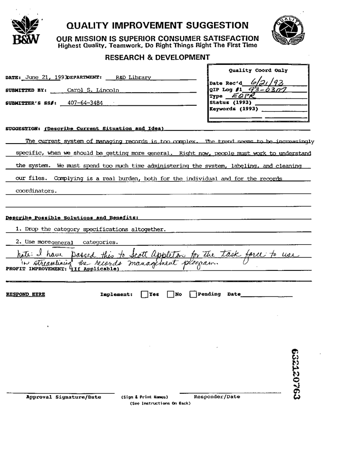

In [3]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(dataset['train'][5]['image_path'])
image = image.convert("RGB")
image.resize((350,450))


In [4]:
dataset['train'][5]

{'id': '5',
 'words': ['DATE:',
  'DEPARTMENT:',
  'Type',
  'EQPR',
  'B&W',
  'QUALITY',
  'Implement:',
  'Date',
  '632120763',
  'QUALITY',
  'IMPROVEMENT',
  'SUGGESTION',
  'OUR',
  'MISSION',
  'IS',
  'SUPERIOR',
  'CONSUMER',
  'SATISFACTION',
  'Highest',
  'Quality.',
  'Teamwork,',
  'Do',
  'Right',
  'Things',
  'Right',
  'The',
  'First',
  'Time',
  'RESEARCH',
  '&',
  'DEVELOPMENT',
  'Quality',
  'Coord',
  'Only',
  'June',
  '21,',
  '1993',
  'R&D',
  'Library',
  'Carol',
  'S.',
  'Lincoln',
  '407-',
  '64-',
  '3484',
  'SUBMITTED',
  'BY:',
  "SUBMITTER'S",
  'SS#:',
  'Date',
  "Rec'd",
  'QIP',
  'Log',
  '#1',
  'Status',
  '(1993)',
  'Keywords',
  '(1993)',
  '6/',
  '21/',
  '93',
  '93-',
  '0301',
  'SUGGESTION:',
  '(Describe',
  'Current',
  'Situation',
  'and',
  'Idea)',
  'The',
  'current',
  'system',
  'of',
  'managing',
  'records',
  'is',
  'too',
  'complex.',
  'The',
  'trend',
  'seems',
  'to',
  'be',
  'increasingly',
  'specific

In [5]:
labels = dataset['train'].features['ner_tags'].feature.names
print(f"Available labels: {labels}")

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [6]:
from transformers import LayoutLMv2Processor

# use LayoutLMv2 processor without ocr since the dataset already includes the ocr text
processor = LayoutLMv2Processor.from_pretrained(processor_id, apply_ocr=False)

In [7]:
from PIL import Image
from functools import partial
from datasets import Features, Sequence, ClassLabel, Value, Array2D


# we need to define custom features
features = Features(
    {
        "input_ids": Sequence(feature=Value(dtype="int64")),
        "attention_mask": Sequence(Value(dtype="int64")),
        "token_type_ids": Sequence(Value(dtype="int64")),
        "bbox": Array2D(dtype="int64", shape=(512, 4)),
        "labels": Sequence(ClassLabel(names=labels)),
    }
)

# preprocess function to perpare into the correct format for the model
def process(sample, processor=None):
    encoding = processor(
        Image.open(sample["image_path"]).convert("RGB"),
        sample["words"],
        boxes=sample["bboxes"],
        word_labels=sample["ner_tags"],
        padding="max_length",
        truncation=True,
    )
    del encoding["image"]
    return encoding


# process the dataset and format it to pytorch
proc_dataset = dataset.map(
    partial(process, processor=processor),
    remove_columns=["image_path", "words", "ner_tags", "id", "bboxes"],
    features=features,
).with_format("torch")

print(proc_dataset["train"].features.keys())
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox','lables'])



dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'])


In [8]:
from transformers import LayoutLMForTokenClassification

# huggingface hub model id
model_id = "microsoft/layoutlm-base-uncased"

# load model with correct number of labels and mapping
model = LayoutLMForTokenClassification.from_pretrained(
    model_id, num_labels=len(labels), label2id=label2id, id2label=id2label
)


Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'layoutlm.embeddings.word_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
import evaluate
import numpy as np

# load seqeval metric
metric = evaluate.load("seqeval")

# labels of the model
ner_labels = list(model.config.id2label.values())


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    all_predictions = []
    all_labels = []
    for prediction, label in zip(predictions, labels):
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == -100:
                continue
            all_predictions.append(ner_labels[predicted_idx])
            all_labels.append(ner_labels[label_idx])
    return metric.compute(predictions=[all_predictions], references=[all_labels])



In [10]:
from torch.cuda import is_available, get_device_capability
from huggingface_hub import HfFolder
from transformers import Trainer, TrainingArguments

# Function to check if the current device supports FP16
def is_fp16_supported():
    if not is_available():
        return False  # FP16 requires CUDA
    major, minor = get_device_capability()
    return major >= 7  # FP16 supported on GPUs with compute capability 7.x and higher

# Hugging Face parameters
repository_id = "layoutlm-funsd"

# Define training arguments, conditionally enabling FP16
training_args = TrainingArguments(
    output_dir=repository_id,
    num_train_epochs=15,
    per_device_train_batch_size=8, 
    per_device_eval_batch_size=4,
    fp16=is_fp16_supported(),  # Only enable FP16 if supported
    learning_rate=3e-5,
    logging_dir=f"{repository_id}/logs",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",
    report_to="none", # esto tiene q ser  "tensorboard"
)
    


# Assuming 'model', 'proc_dataset', and 'compute_metrics' are already defined
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=proc_dataset["train"],
    eval_dataset=proc_dataset["test"],
    compute_metrics=compute_metrics,
)


In [20]:
# Start training
trainer.train()

  1%|          | 3/285 [07:03<11:40:23, 149.02s/it]

KeyboardInterrupt: 

In [11]:
# change apply_ocr to True to use the ocr text for inference
processor.feature_extractor.apply_ocr = True

# Save processor and create model card
processor.save_pretrained(repository_id)
trainer.create_model_card()


/Users/noramendoza/Library/Python/3.9/lib/python/site-packages/transformers/models/layoutlmv2/processing_layoutlmv2.py:197: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
